Rishi's EDA file

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

In [4]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset

# Model and evaluation
from models.id_only_mf import MatrixFactorization
from evaluation import evaluate_ranking_model

In [5]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


In [14]:
data_dir = "../data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
len(ratings), len(users), len(movies)

(1000209, 6040, 3883)

# Ratings exploration

All ratings are valid

In [15]:
valid_ids = set(movies["MovieID"])
ratings = ratings[ratings["MovieID"].isin(valid_ids)].copy()
len(ratings)

1000209

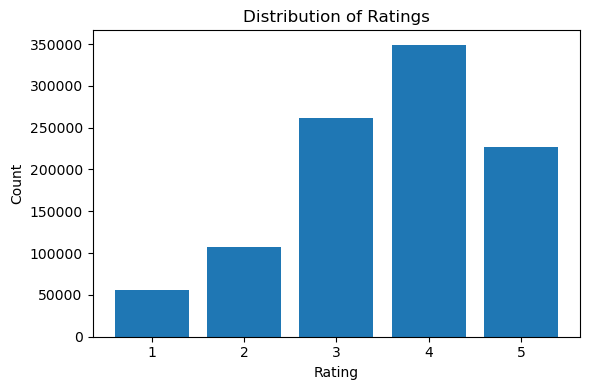

In [17]:
rating_counts = ratings['Rating'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.tight_layout()
plt.show()

In [27]:
rating_proportions = (100* rating_counts / rating_counts.sum()).reset_index()
rating_proportions.columns = ['Rating', '%']
print(rating_proportions)

   Rating          %
0       1   5.616226
1       2  10.753453
2       3  26.114242
3       4  34.889808
4       5  22.626271


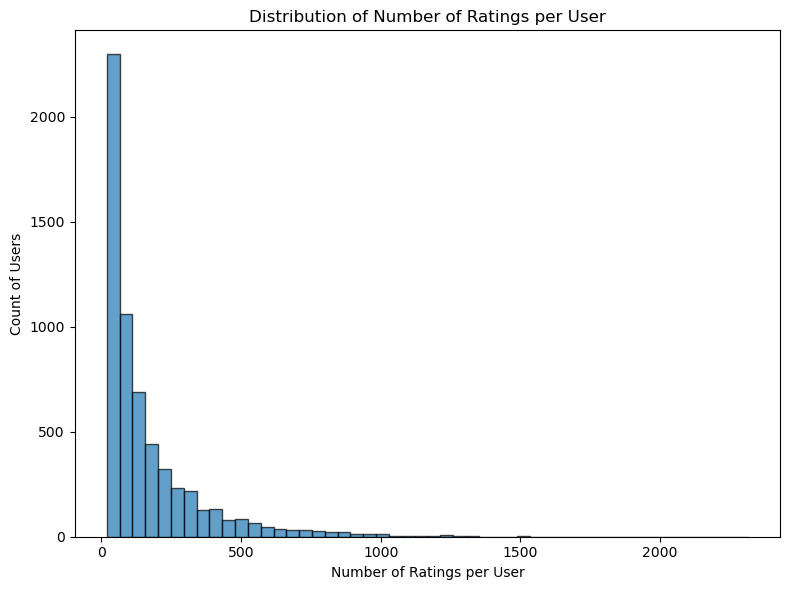

In [28]:
user_rating_counts = ratings.groupby('UserID').size()

plt.figure(figsize=(8, 6))
plt.hist(user_rating_counts, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Count of Users')
plt.title('Distribution of Number of Ratings per User')
plt.tight_layout()
plt.show()

All users have at least 20 ratings in this dataset

In [41]:
user_rating_counts.min()

20

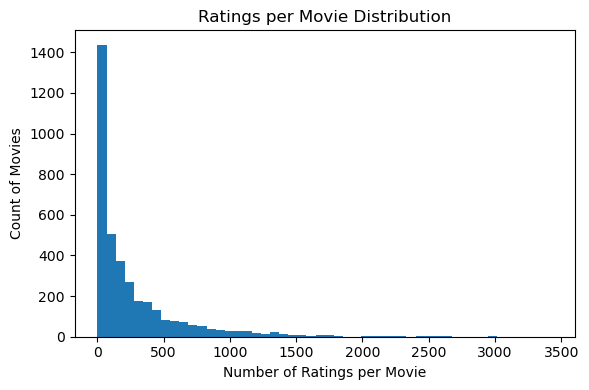

In [43]:
ratings_per_movie = ratings.groupby('MovieID').size()

plt.figure(figsize=(6,4))
plt.hist(ratings_per_movie, bins=50)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Count of Movies')
plt.title('Ratings per Movie Distribution')
plt.tight_layout()
plt.show()

In [50]:
p99 = ratings_per_movie.quantile(0.95)
p01 = ratings_per_movie.quantile(0.05)

print(f"99th Percentile (p99): {p99}")
print(f"1st Percentile (p01): {p01}")

99th Percentile (p99): 1051.5
1st Percentile (p01): 2.0


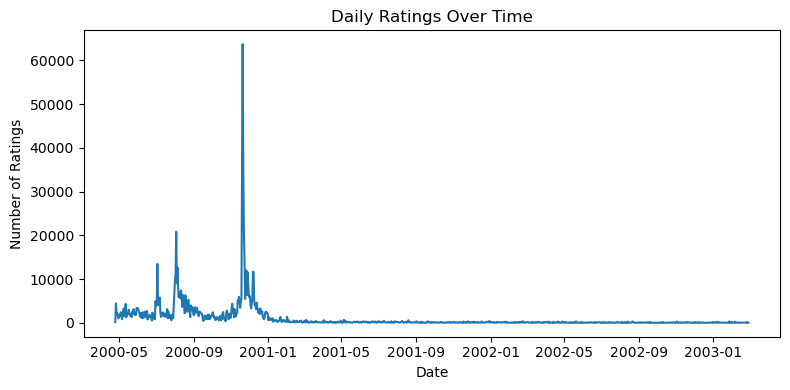

In [53]:
import pandas as pd

# assume df is your DataFrame
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')

daily_counts = ratings.set_index('Datetime').resample('D').size()

plt.figure(figsize=(8,4))
plt.plot(daily_counts.index, daily_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Daily Ratings Over Time')
plt.tight_layout()
plt.show()

/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_68750/2164277044.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = ratings.set_index('Datetime')['Rating'].resample('M').mean()


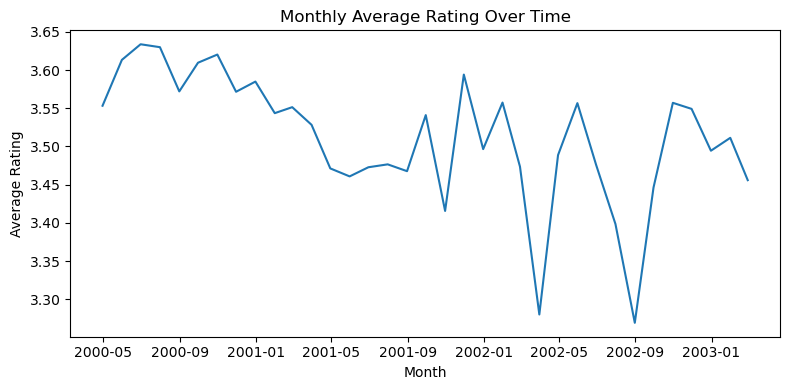

In [54]:
monthly_avg = ratings.set_index('Datetime')['Rating'].resample('M').mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values)
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Monthly Average Rating Over Time')
plt.tight_layout()
plt.show()

# Movies

In [55]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [56]:
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)').astype(int)
movies


,MovieID,Title,Genres,Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000
3879,3949,Requiem for a Dream (2000),Drama,2000
3880,3950,Tigerland (2000),Drama,2000
3881,3951,Two Family House (2000),Drama,2000


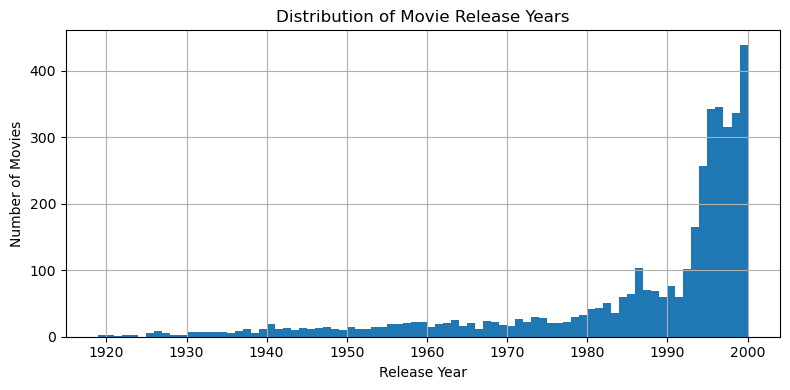

In [57]:
# Distribution of Release Years
plt.figure(figsize=(8,4))
movies['Year'].hist(bins=range(movies['Year'].min(),
                               movies['Year'].max()+1, 1))
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Release Years')
plt.tight_layout()
plt.show()

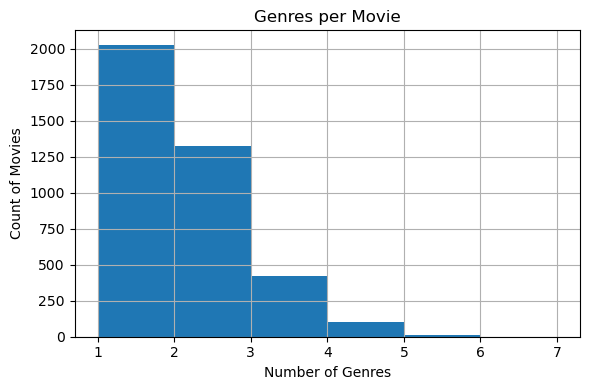

In [58]:
# Number of Genres per Movie
movies['NumGenres'] = movies['Genres'].str.count('\|') + 1
plt.figure(figsize=(6,4))
movies['NumGenres'].hist(bins=range(1,
                                    movies['NumGenres'].max()+2))
plt.xlabel('Number of Genres')
plt.ylabel('Count of Movies')
plt.title('Genres per Movie')
plt.tight_layout()
plt.show()

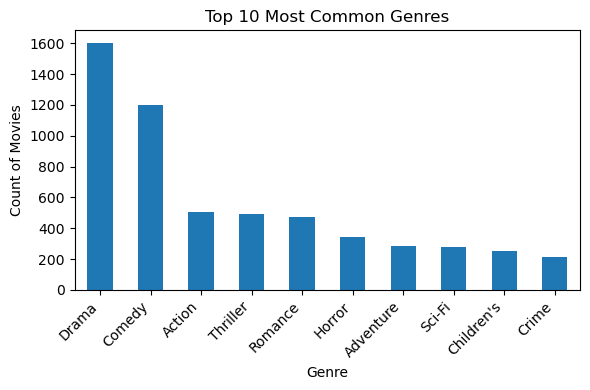

In [59]:
# Top 10 Most Common Genres
genre_exploded = movies['Genres'].str.split('|').explode()
top_genres = genre_exploded.value_counts().head(10)
plt.figure(figsize=(6,4))
top_genres.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count of Movies')
plt.title('Top 10 Most Common Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

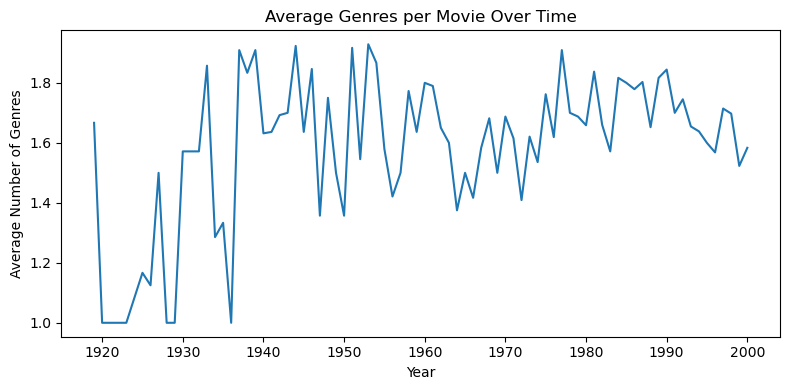

In [60]:
# Average Genre Count per Movie Over Time
year_genre = movies.groupby('Year')['NumGenres'].mean()
plt.figure(figsize=(8,4))
year_genre.plot()
plt.xlabel('Year')
plt.ylabel('Average Number of Genres')
plt.title('Average Genres per Movie Over Time')
plt.tight_layout()
plt.show()

# Users

In [61]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


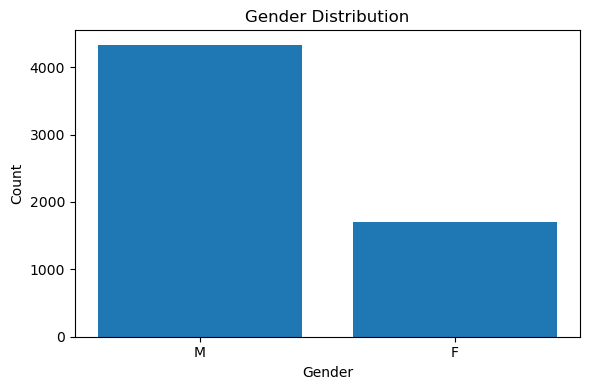

In [62]:
# Gender
plt.figure(figsize=(6,4))
gender_counts = users['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

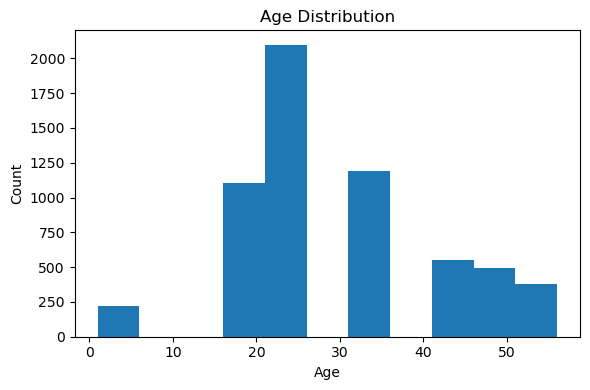

In [63]:
# Age
plt.figure(figsize=(6,4))
plt.hist(users['Age'], bins=range(users['Age'].min(),
                                  users['Age'].max()+5, 5))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.tight_layout()
plt.show()

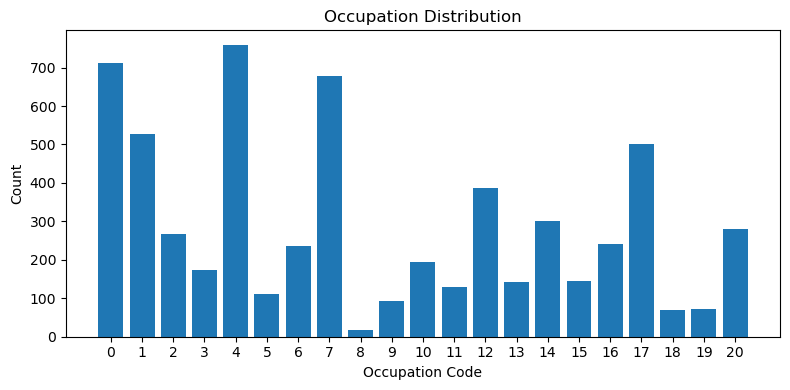

In [64]:
# Occupation
occ_counts = users['Occupation'].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar(occ_counts.index.astype(str), occ_counts.values)
plt.xlabel('Occupation Code')
plt.ylabel('Count')
plt.title('Occupation Distribution')
plt.tight_layout()
plt.show()

# Combined

In [65]:
# 1) Merge ratings with user info
df = ratings.merge(
    users,
    on='UserID',
    how='left'     # or 'inner' if you want to drop any stray ratings/users
)

# 2) Merge the result with movie info
df = df.merge(
    movies,
    on='MovieID',
    how='left'     # again, 'inner' if you only want movies present in both
)

# 3) Inspect
print(df.shape)   # e.g. (num_ratings, num_columns)
print(df.columns)
print(df.head())

(1000209, 13)
Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Datetime', 'Gender', 'Age',
       'Occupation', 'Zip-code', 'Title', 'Genres', 'Year', 'NumGenres'],
      dtype='object')
   UserID  MovieID  Rating  Timestamp            Datetime Gender  Age  \
0       1     1193       5  978300760 2000-12-31 22:12:40      F    1   
1       1      661       3  978302109 2000-12-31 22:35:09      F    1   
2       1      914       3  978301968 2000-12-31 22:32:48      F    1   
3       1     3408       4  978300275 2000-12-31 22:04:35      F    1   
4       1     2355       5  978824291 2001-01-06 23:38:11      F    1   

   Occupation Zip-code                                   Title  \
0          10    48067  One Flew Over the Cuckoo's Nest (1975)   
1          10    48067        James and the Giant Peach (1996)   
2          10    48067                     My Fair Lady (1964)   
3          10    48067                  Erin Brockovich (2000)   
4          10    48067                   

<Figure size 600x400 with 0 Axes>

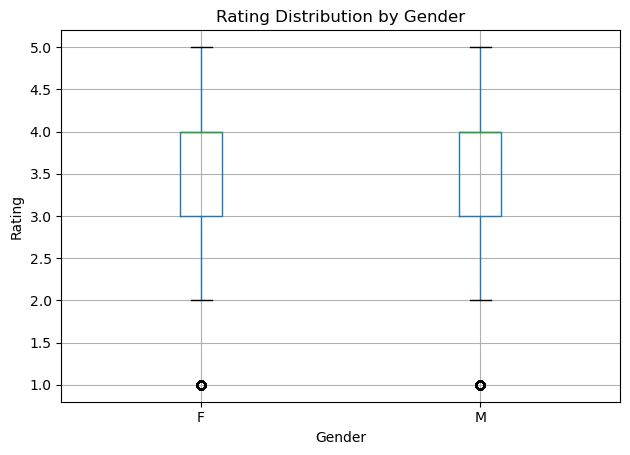

In [66]:
plt.figure(figsize=(6,4))
df.boxplot(column='Rating', by='Gender')
plt.suptitle('')   # remove the default title
plt.xlabel('Gender')
plt.ylabel('Rating')
plt.title('Rating Distribution by Gender')
plt.tight_layout()
plt.show()

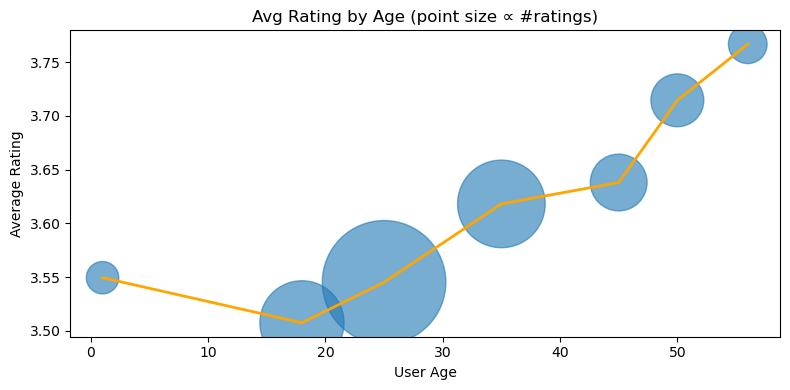

In [67]:
# Compute average rating per age
age_stats = df.groupby('Age')['Rating'].agg(['mean','count'])

plt.figure(figsize=(8,4))
plt.scatter(age_stats.index, age_stats['mean'], s=age_stats['count']/50, alpha=0.6)
plt.plot(age_stats.index, age_stats['mean'], color='orange', lw=2)
plt.xlabel('User Age')
plt.ylabel('Average Rating')
plt.title('Avg Rating by Age (point size ∝ #ratings)')
plt.tight_layout()
plt.show()

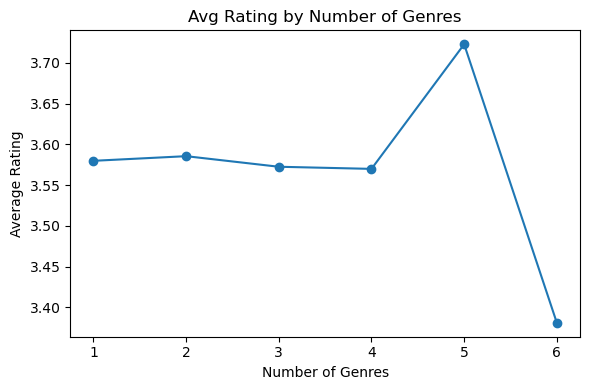

In [68]:
# average rating by genre count
genre_stats = df.groupby('NumGenres')['Rating'].mean()

plt.figure(figsize=(6,4))
genre_stats.plot(marker='o')
plt.xlabel('Number of Genres')
plt.ylabel('Average Rating')
plt.title('Avg Rating by Number of Genres')
plt.tight_layout()
plt.show()

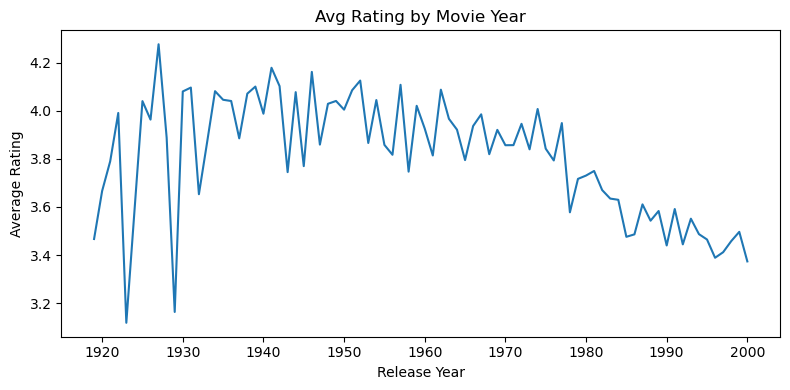

In [69]:
year_stats = df.groupby('Year')['Rating'].mean()

plt.figure(figsize=(8,4))
year_stats.plot()
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Avg Rating by Movie Year')
plt.tight_layout()
plt.show()

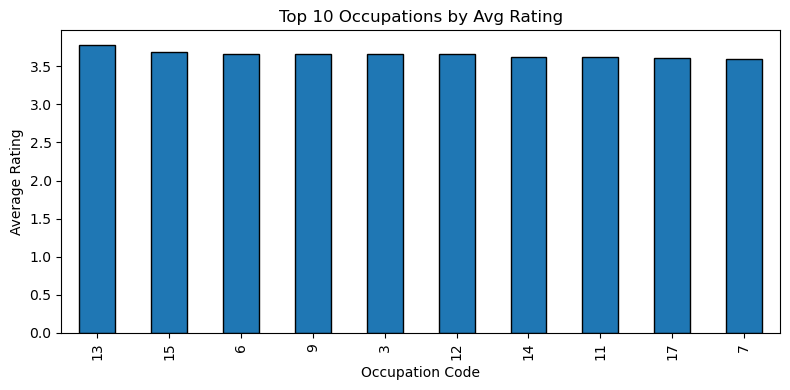

In [70]:
occ_stats = df.groupby('Occupation')['Rating']\
              .mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
occ_stats.plot(kind='bar', edgecolor='black')
plt.xlabel('Occupation Code')
plt.ylabel('Average Rating')
plt.title('Top 10 Occupations by Avg Rating')
plt.tight_layout()
plt.show()

   UserID  rating_mean  rating_std  num_ratings
0       1     4.188679    0.680967           53
1       2     3.713178    1.001513          129
2       3     3.901961    0.984985           51
3       4     4.190476    1.077917           21
4       5     3.146465    1.132699          198
5       6     3.901408    0.830747           71
6       7     4.322581    0.747757           31
7       8     3.884892    0.925321          139
8       9     3.735849    0.820010          106
9      10     4.114713    0.837740          401


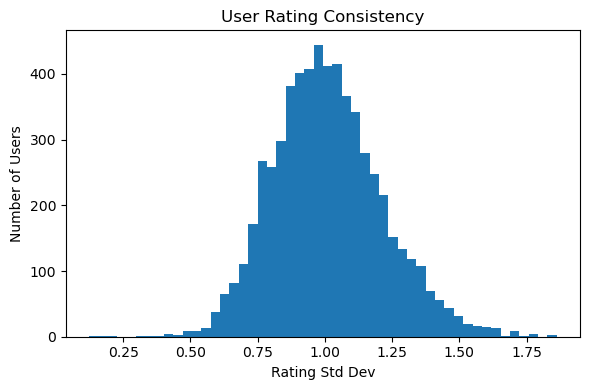

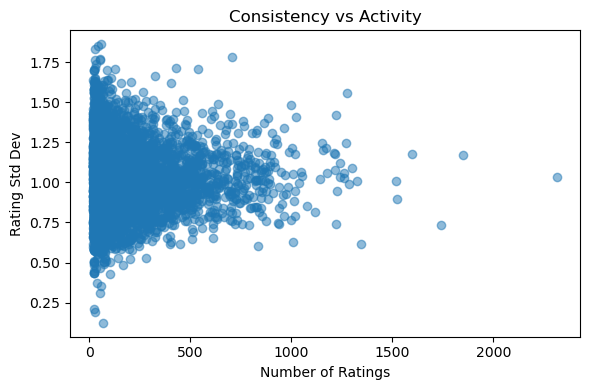

Most consistent users:
       UserID  rating_mean  rating_std  num_ratings
3597    3598     1.015385    0.124035           65
282      283     4.962963    0.192450           27
2338    2339     4.956522    0.208514           23
4485    4486     1.058824    0.310597           51
5067    5068     4.054545    0.355808           55

Least consistent users:
       UserID  rating_mean  rating_std  num_ratings
86        87     2.813559    1.861354           59
4895    4896     3.073171    1.849192           41
1101    1102     2.259259    1.831195           27
3475    3476     2.622695    1.780432          705
4492    4493     2.340000    1.768315           50


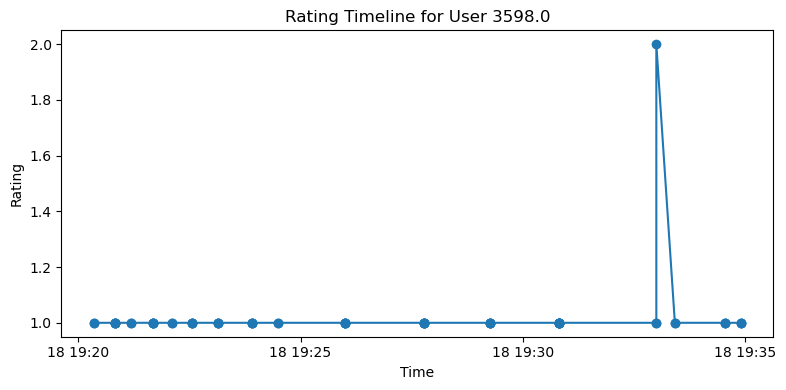

In [71]:

user_stats = df.groupby('UserID')['Rating'] \
               .agg(['mean','std','count']) \
               .rename(columns={'mean':'rating_mean',
                                'std':'rating_std',
                                'count':'num_ratings'}) \
               .reset_index()

# 3) Show a few users’ stats
print(user_stats.head(10))

# 4) Plot distribution of rating standard deviation
plt.figure(figsize=(6,4))
plt.hist(user_stats['rating_std'].dropna(), bins=50)
plt.xlabel('Rating Std Dev')
plt.ylabel('Number of Users')
plt.title('User Rating Consistency')
plt.tight_layout()
plt.show()

# 5) Plot rating_std vs num_ratings to see if activity affects consistency
plt.figure(figsize=(6,4))
plt.scatter(user_stats['num_ratings'],
            user_stats['rating_std'],
            alpha=0.5)
plt.xlabel('Number of Ratings')
plt.ylabel('Rating Std Dev')
plt.title('Consistency vs Activity')
plt.tight_layout()
plt.show()

# 6) Inspect a few extreme cases
most_consistent = user_stats.nsmallest(5, 'rating_std')
least_consistent = user_stats.nlargest(5, 'rating_std')
print("Most consistent users:\n", most_consistent)
print("\nLeast consistent users:\n", least_consistent)

# 7) Time series for an example user to visualize consistency over time
example_user = most_consistent.iloc[0]['UserID']
ts = df[df['UserID']==example_user].sort_values('Datetime')
plt.figure(figsize=(8,4))
plt.plot(ts['Datetime'], ts['Rating'], marker='o')
plt.xlabel('Time')
plt.ylabel('Rating')
plt.title(f'Rating Timeline for User {example_user}')
plt.tight_layout()
plt.show()